# Notebook for Scor-O - Viz
- reads in the table of season's scores and outputs a vizualization of the density of result combinations

In [146]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from dateutil.relativedelta import relativedelta


# Load Results Table - in the format of CHN Schedule Tables
filename = 'CHN_Schedule_Sunday_Test1'
data_path = os.path.join('..', 'data', 'schedule', f'{filename}.csv')
data = pd.read_csv(data_path) # Load to dataframe

data.head() # Check Dataframe

,Date,Conference,Game_Notes,Away_Team,Away_Team_Link,Away_Score,Home_Team,Home_Team_Link,Home_Score,OT,Box_Link,Metrics_Link,Day,Game_ID
0,2024-10-04,Non-Conference,NaN,Michigan State,/reports/team/Michigan-State/32,2.0,Lake Superior,/reports/team/Lake-Superior/24,1.0,ot,/box/final/20241004/msu/lss/,/box/metrics.php?gd=100540,Friday,2024-10-04-LakeSuperior-MichiganState
1,2024-10-04,Non-Conference,NaN,Minnesota State,/reports/team/Minnesota-State/35,5.0,Michigan,/reports/team/Michigan/31,2.0,NaN,/box/final/20241004/mns/mic/,/box/metrics.php?gd=100317,Friday,2024-10-04-Michigan-MinnesotaState
2,2024-10-04,Non-Conference,NaN,Arizona State,/reports/team/Arizona-State/61,8.0,Air Force,/reports/team/Air-Force/1,1.0,NaN,/box/final/20241004/asu/afa/,/box/metrics.php?gd=99879,Friday,2024-10-04-AirForce-ArizonaState
3,2024-10-04,Non-Conference,NaN,Bowling Green,/reports/team/Bowling-Green/11,2.0,Mercyhurst,/reports/team/Mercyhurst/28,1.0,NaN,/box/final/20241004/bgs/mrc/,/box/metrics.php?gd=100386,Friday,2024-10-04-Mercyhurst-BowlingGreen
4,2024-10-04,Non-Conference,NaN,Colgate,/reports/team/Colgate/15,2.0,Connecticut,/reports/team/Connecticut/17,4.0,NaN,/box/final/20241004/clg/con/,/box/metrics.php?gd=100832,Friday,2024-10-04-Connecticut-Colgate


## Data Transform

In [147]:

# Filter out exhibition games
filtered_data = data[data['Conference'] != 'Exhibition']

# Determine the maximum scores for both home and away teams to set up the axes
# and make sure they are integers
max_home_score = filtered_data['Home_Score'].max()
max_away_score = filtered_data['Away_Score'].max()
max_home_score, max_away_score = int(max_home_score), int(max_away_score)

# Calculate the total home wins (Home_Score > Away_Score)
home_wins = len(filtered_data[filtered_data['Home_Score'] > filtered_data['Away_Score']])

# Calculate the total away wins (Away_Score > Home_Score)
away_wins = len(filtered_data[filtered_data['Away_Score'] > filtered_data['Home_Score']])

# Calculate ties, if any (optional)
ties = len(filtered_data[filtered_data['Home_Score'] == filtered_data['Away_Score']])



# Create a pivot table to aggregate game counts for each score combination
score_combinations = pd.pivot_table(filtered_data, index='Home_Score', columns='Away_Score', values='Date', aggfunc='count', fill_value=0)

# Fill in any missing score combinations with zeros (in case some scores don't appear in the dataset)
all_scores = np.arange(0, max(max_home_score, max_away_score) + 1)  # +1 to include the max score itself
score_combinations = score_combinations.reindex(index=all_scores, columns=all_scores, fill_value=0)
# Make sure the numbers in the headers pivot table are integers
score_combinations = score_combinations.astype(int)
score_combinations

# data.head()

Away_Score,0,1,2,3,4,5,6,7,8
Home_Score,,,,,,,,,
0,0,1,0,0,0,1,0,0,0
1,0,0,2,0,1,1,0,0,1
2,0,1,0,2,0,1,1,0,0
3,0,0,1,1,2,0,0,0,0
4,0,1,1,3,1,2,0,0,0
5,0,0,2,0,0,0,0,0,0
6,1,0,1,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0


## Basic Plotting Code
- taken from 2023-24 project workbook

In [148]:
# # Create a mask where the data is 0
# mask = score_combinations == 0

# # Customizing the colormap: add a transparent color for 0 values
# # We take the original colormap, add a transparent color for 0 and keep the rest as is.
# # This example uses "YlGnBu", but you can change it to your preferred colormap.
# cmap = sns.color_palette("YlGnBu", as_cmap=True)
# cmap_with_transparency = ListedColormap([(0,0,0,0)] + [cmap(i) for i in range(1, cmap.N)])

# # Plotting the heatmap with modifications
# plt.figure(figsize=(12, 10))
# sns.heatmap(score_combinations, annot=True, mask=mask, cmap=cmap_with_transparency, fmt="d", linewidths=.5,
#             cbar_kws={'ticks': range(1, max(max_home_score, max_away_score) + 1)})  # Adjust colorbar ticks if necessary
# plt.title('College Hockey Game Scoreboard Bingo', fontsize=16)
# # Add a note of the start and end dates - under the title in upper right of the plot

# plt.xlabel('Away Team', fontsize=14) # Set to Blank to remove the label
# plt.ylabel('Home Team', fontsize=14) # Set to Blank to remove the label
# plt.xticks(np.arange(0.5, len(all_scores)+0.5, 1), all_scores)
# plt.yticks(np.arange(0.5, len(all_scores)+0.5, 1), all_scores, rotation=0)

# # Custom function to make text annotations transparent for 0 values
# for text in plt.gca().texts:
#     if text.get_text() == '0':
#         text.set_alpha(0)

# # Invert y-axis so 0 is at the bottom
# plt.gca().invert_yaxis()




# ## Set Hard Coded axis ranges
# # plt.xlim(0, 15)
# # plt.ylim(0, 15)




# # plt.show()


## Version 1.1

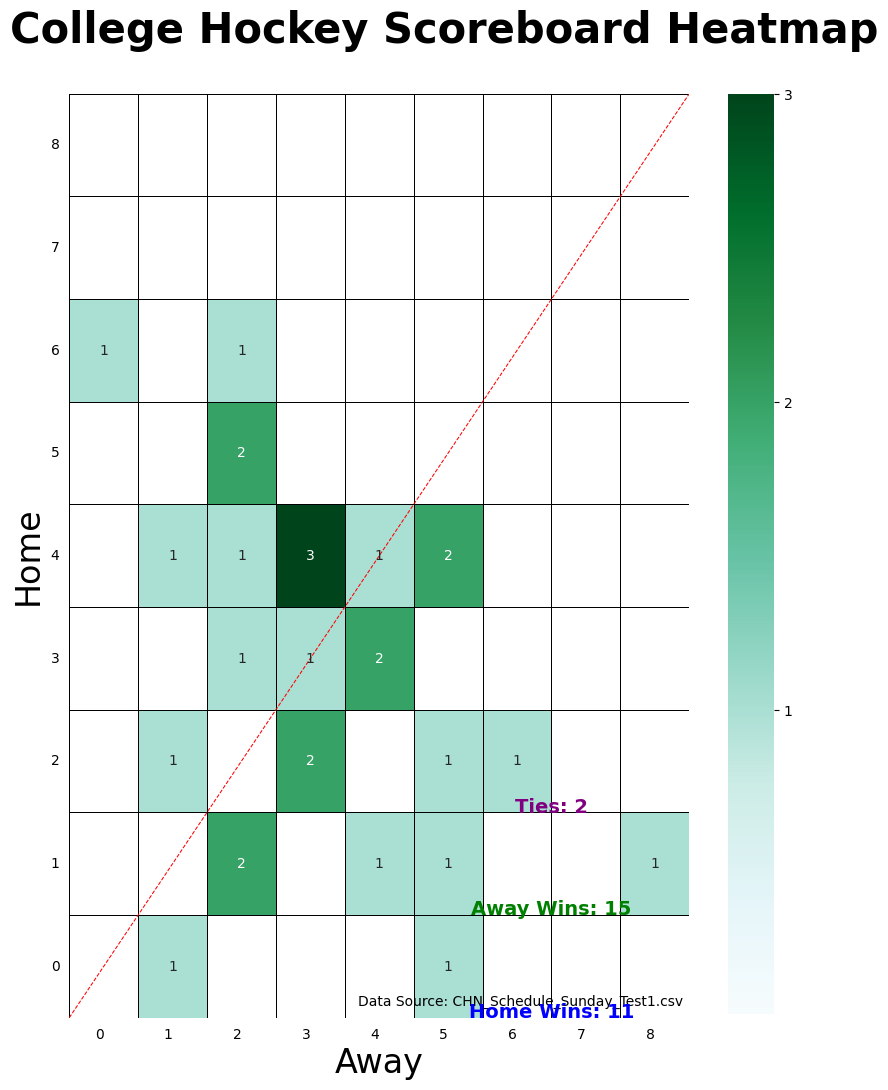

In [149]:
###### TEMPORATRY - EVENTUALLY WANT TO READ THE DATE OF DATA FILE AND AUTOMATICALLY UPDATE FOR THE ANNOTATION
date = '10/6/24'

figure_ratio = (10,12)

color_set = 'BuGn'
## Browse the color palettes here: https://seaborn.pydata.org/tutorial/color_palettes.html
### OR https://www.practicalpythonfordatascience.com/ap_seaborn_palette


# Customizing the colormap: add a transparent color for 0 values
cmap = sns.color_palette(palette=color_set, as_cmap=True)
cmap_with_transparency = ListedColormap([(0,0,0,0)] + [cmap(i) for i in range(1, cmap.N)])

# Plotting the heatmap with modifications
plt.figure(figsize=figure_ratio)
sns.heatmap(score_combinations, annot=True, mask=None, cmap=cmap_with_transparency, fmt="d", linewidths=.5, 
            linecolor='black', cbar_kws={'ticks': range(1, max(max_home_score, max_away_score) + 1)})


# Add title and subtitle
plt.suptitle('College Hockey Scoreboard Heatmap', fontsize=30, fontweight='bold', color='black', x=0.5, y=0.95)

# add data source and data annotation to bottom right of the plot
plt.text(0.99, 0.01, f'Data Source: {filename}.csv', fontsize=10, color='black', ha='right', va='bottom', transform=plt.gca().transAxes)

# Axis Labels
plt.xlabel('Away', fontsize=24)
plt.ylabel('Home', fontsize=24)
# Remove tick marks
plt.tick_params(axis='both', which='both', bottom=False, left=False)
plt.xticks(np.arange(0.5, len(all_scores)+0.5, 1), all_scores, rotation=0, ha="right")  # Rotating x-ticks slightly
plt.yticks(np.arange(0.5, len(all_scores)+0.5, 1), all_scores, rotation=0)

# Custom function to make text annotations transparent for 0 values
for text in plt.gca().texts:
    if text.get_text() == '0':
        text.set_alpha(0)

### HOME VS AWAY DIFF LINE
# Add the x = y diagonal line
plt.plot([0, len(all_scores)], [0, len(all_scores)], color='red', linestyle='--', linewidth=.75)


# Add a leaderboard for home vs away record
# Add leaderboard text inside the plot (you can adjust the position)
plt.text(7, 0, f'Home Wins: {home_wins}', fontsize=14, color='blue', fontweight='bold', ha='center')
plt.text(7, 1, f'Away Wins: {away_wins}', fontsize=14, color='green', fontweight='bold', ha='center')
plt.text(7, 2, f'Ties: {ties}', fontsize=14, color='purple', fontweight='bold', ha='center')


# Invert y-axis so 0 is at the bottom
plt.gca().invert_yaxis()

# Tight Layout Option
# plt.tight_layout()

plt.show()


## Version 2.0 - 2.1

In [150]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# from matplotlib.colors import ListedColormap

# # Define figure size
# figure_ratio = (8, 10)  # Wide format, good for Reddit posts

# # Customizing the colormap with transparency for zeros
# cmap = sns.color_palette(palette='coolwarm', as_cmap=True)
# cmap_with_transparency = ListedColormap([(0,0,0,0)] + [cmap(i) for i in range(1, cmap.N)])

# # Plotting the heatmap with a 1:1 aspect ratio for the grid
# plt.figure(figsize=figure_ratio)
# ax = sns.heatmap(score_combinations, annot=True, mask=None, cmap=cmap_with_transparency, fmt="d", linewidths=.25, 
#                  linecolor='gray', cbar_kws={'ticks': range(1, max(max_home_score, max_away_score) + 1)}, square=True)

# # Add main title with modern font and better placement
# plt.suptitle('College Hockey Scoreboard Heatmap', fontsize=24, fontweight='bold', color='black', y=1.05)

# # Add data source and date
# plt.text(1, -0.15, f'Data Source: {filename}.csv | Games Through {date}', fontsize=10, color='black', ha='right', va='bottom', transform=plt.gca().transAxes)

# # Axis labels
# plt.xlabel('Away', fontsize=18, labelpad=15)
# plt.ylabel('Home', fontsize=18, labelpad=15)

# # Customize tick labels
# plt.xticks(np.arange(0.5, len(all_scores)+0.5, 1), all_scores, rotation=0, ha="center", fontsize=12)
# plt.yticks(np.arange(0.5, len(all_scores)+0.5, 1), all_scores, rotation=0, fontsize=12)

# # Add a diagonal line for home vs away parity
# plt.plot([0, len(all_scores)], [0, len(all_scores)], color='red', linestyle='--', linewidth=1)

# # Leaderboard box for home vs away record
# props = dict(boxstyle='round,pad=0.5', facecolor='lightgray', edgecolor='black')
# leaderboard_text = f'Home Wins: {home_wins}\nAway Wins: {away_wins}\nTies: {ties}'
# plt.text(1.05, 0.5, leaderboard_text, fontsize=14, color='black', transform=plt.gca().transAxes, verticalalignment='center', bbox=props)

# # Invert y-axis to ensure 0 is at the bottom
# plt.gca().invert_yaxis()

# # Tight layout ensures everything fits within the figure
# plt.tight_layout()

# plt.show()


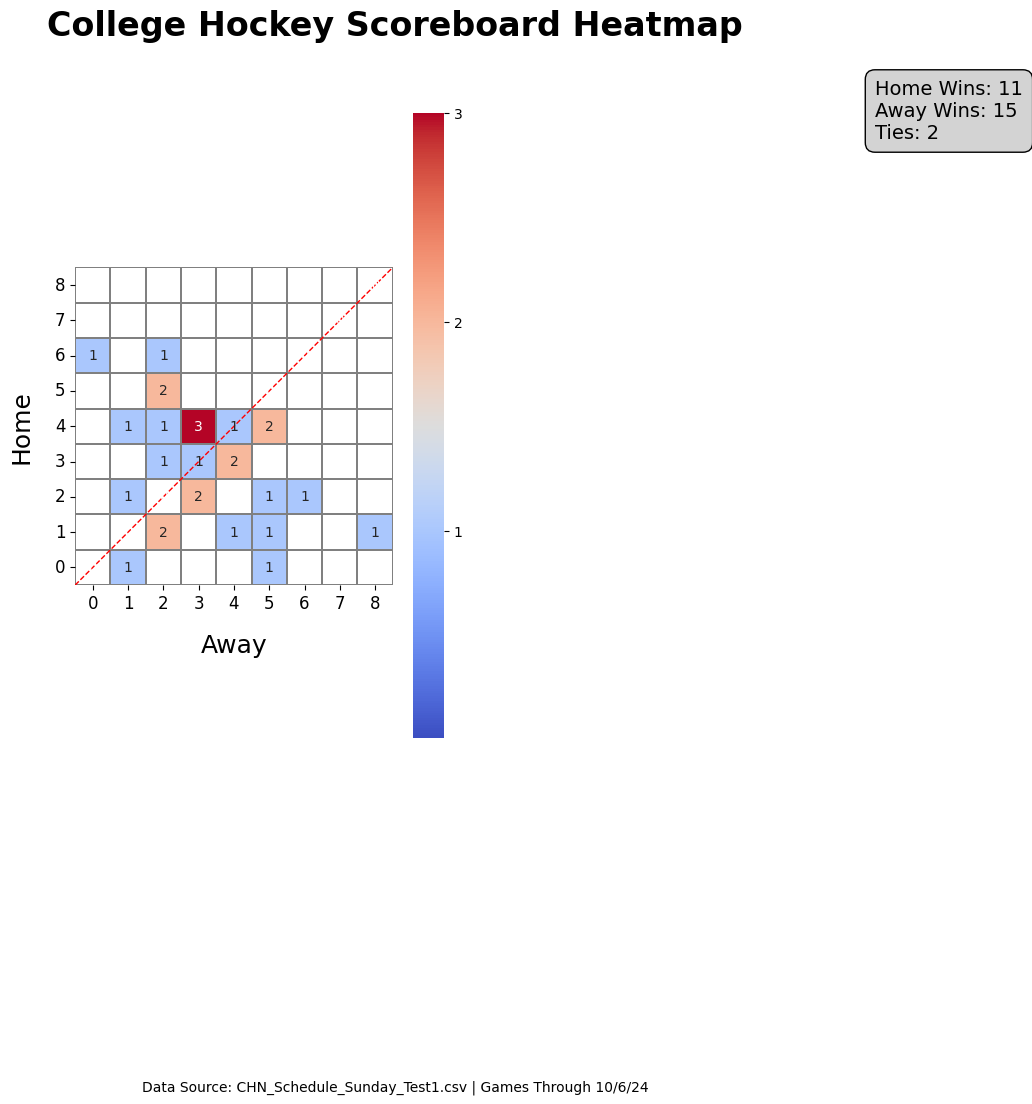

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap

# Define figure size to maintain a 4:5 ratio while ensuring the heatmap grid stays 1:1
figure_ratio = (8, 10)  # Adjusted for mobile-friendly aspect ratio

# Customizing the colormap with transparency for zeros
cmap = sns.color_palette(palette='coolwarm', as_cmap=True)
cmap_with_transparency = ListedColormap([(0,0,0,0)] + [cmap(i) for i in range(1, cmap.N)])

# Create a figure with constrained layout to ensure the grid aspect stays 1:1
fig, ax = plt.subplots(figsize=figure_ratio)
sns.heatmap(score_combinations, annot=True, mask=None, cmap=cmap_with_transparency, fmt="d", linewidths=.25, 
            linecolor='gray', cbar_kws={'ticks': range(1, max(max_home_score, max_away_score) + 1)}, square=True, ax=ax)

# Add main title with modern font and better placement
plt.suptitle('College Hockey Scoreboard Heatmap', fontsize=24, fontweight='bold', color='black', y=0.97)

# Add data source and date below the heatmap
plt.text(0.5, -0.1, f'Data Source: {filename}.csv | Games Through {date}', fontsize=10, color='black', ha='center', va='top', transform=fig.transFigure)

# Axis labels
plt.xlabel('Away', fontsize=18, labelpad=15)
plt.ylabel('Home', fontsize=18, labelpad=15)

# Customize tick labels
plt.xticks(np.arange(0.5, len(all_scores)+0.5, 1), all_scores, rotation=0, ha="center", fontsize=12)
plt.yticks(np.arange(0.5, len(all_scores)+0.5, 1), all_scores, rotation=0, fontsize=12)

# Add a diagonal line for home vs away parity
plt.plot([0, len(all_scores)], [0, len(all_scores)], color='red', linestyle='--', linewidth=1)

# Move the leaderboard to the top-right corner to avoid overlapping with the colorbar
props = dict(boxstyle='round,pad=0.5', facecolor='lightgray', edgecolor='black')
leaderboard_text = f'Home Wins: {home_wins}\nAway Wins: {away_wins}\nTies: {ties}'
plt.text(1.1, 0.9, leaderboard_text, fontsize=14, color='black', transform=fig.transFigure, verticalalignment='top', bbox=props)

# Invert y-axis to ensure 0 is at the bottom
plt.gca().invert_yaxis()

# Tight layout ensures everything fits within the figure
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


C:\Users\jbanc\AppData\Local\Temp\ipykernel_10836\2788763247.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


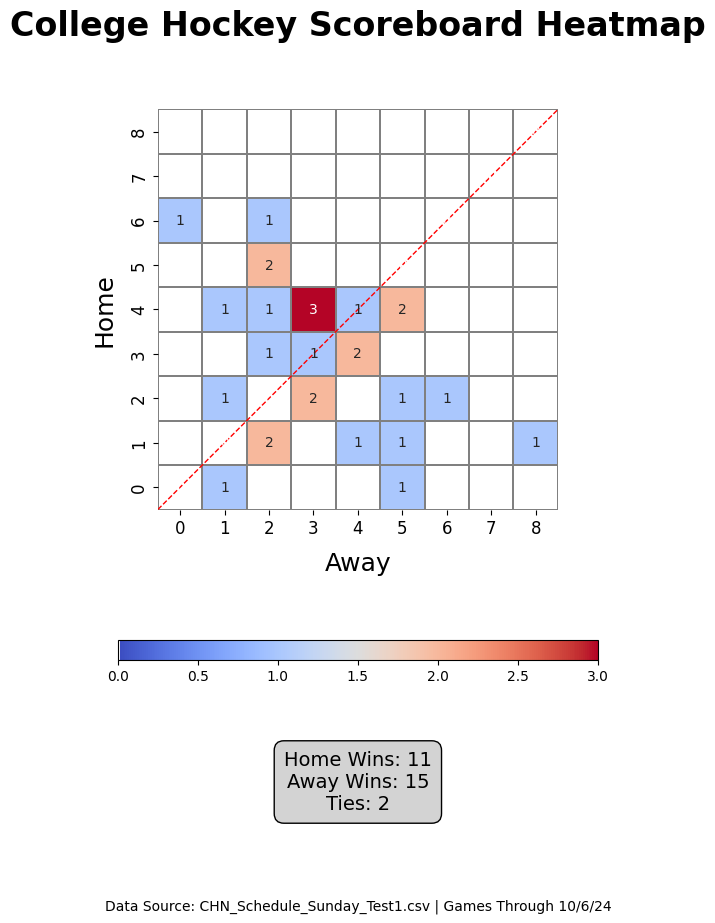

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap

# Define figure size to maintain a 4:5 ratio while ensuring the heatmap grid stays 1:1
figure_ratio = (8, 10)  # Adjusted for mobile-friendly aspect ratio

# Customizing the colormap with transparency for zeros
cmap = sns.color_palette(palette='coolwarm', as_cmap=True)
cmap_with_transparency = ListedColormap([(0,0,0,0)] + [cmap(i) for i in range(1, cmap.N)])

# Create a figure with constrained layout to ensure the grid aspect stays 1:1
fig = plt.figure(figsize=figure_ratio)

# Create the title
plt.suptitle('College Hockey Scoreboard Heatmap', fontsize=24, fontweight='bold', color='black', y=0.95)

# Create a new axis for the heatmap with the grid maintaining a 1:1 aspect ratio
ax1 = fig.add_axes([0.1, 0.45, 0.8, 0.4])  # Adjust the placement and size of the heatmap
sns.heatmap(score_combinations, annot=True, mask=None, cmap=cmap_with_transparency, fmt="d", linewidths=.25, 
            linecolor='gray', cbar=False, square=True, ax=ax1)

# Invert y-axis to ensure 0 is at the bottom
ax1.invert_yaxis()

# Axis labels
ax1.set_xlabel('Away', fontsize=18, labelpad=10)
ax1.set_ylabel('Home', fontsize=18, labelpad=10)

# Customize tick labels
ax1.set_xticks(np.arange(0.5, len(all_scores)+0.5, 1))
ax1.set_xticklabels(all_scores, fontsize=12)
ax1.set_yticks(np.arange(0.5, len(all_scores)+0.5, 1))
ax1.set_yticklabels(all_scores, fontsize=12)

# Add a diagonal line for home vs away parity
ax1.plot([0, len(all_scores)], [0, len(all_scores)], color='red', linestyle='--', linewidth=1)

# Create a new axis for the color bar below the heatmap
ax2 = fig.add_axes([0.2, 0.3, 0.6, 0.02])  # Adjust placement for color bar
cbar = plt.colorbar(ax1.collections[0], cax=ax2, orientation='horizontal')
# cbar.set_label('Game Frequency', fontsize=14)

# Add the leaderboard box below the color bar
props = dict(boxstyle='round,pad=0.5', facecolor='lightgray', edgecolor='black')
leaderboard_text = f'Home Wins: {home_wins}\nAway Wins: {away_wins}\nTies: {ties}'
plt.text(0.5, 0.15, leaderboard_text, fontsize=14, color='black', ha='center', bbox=props, transform=fig.transFigure)

# Add data source and date at the very bottom
plt.figtext(0.5, 0.05, f'Data Source: {filename}.csv | Games Through {date}', fontsize=10, color='black', ha='center')

# Tight Layout
plt.tight_layout()
# Display the plot
plt.show()


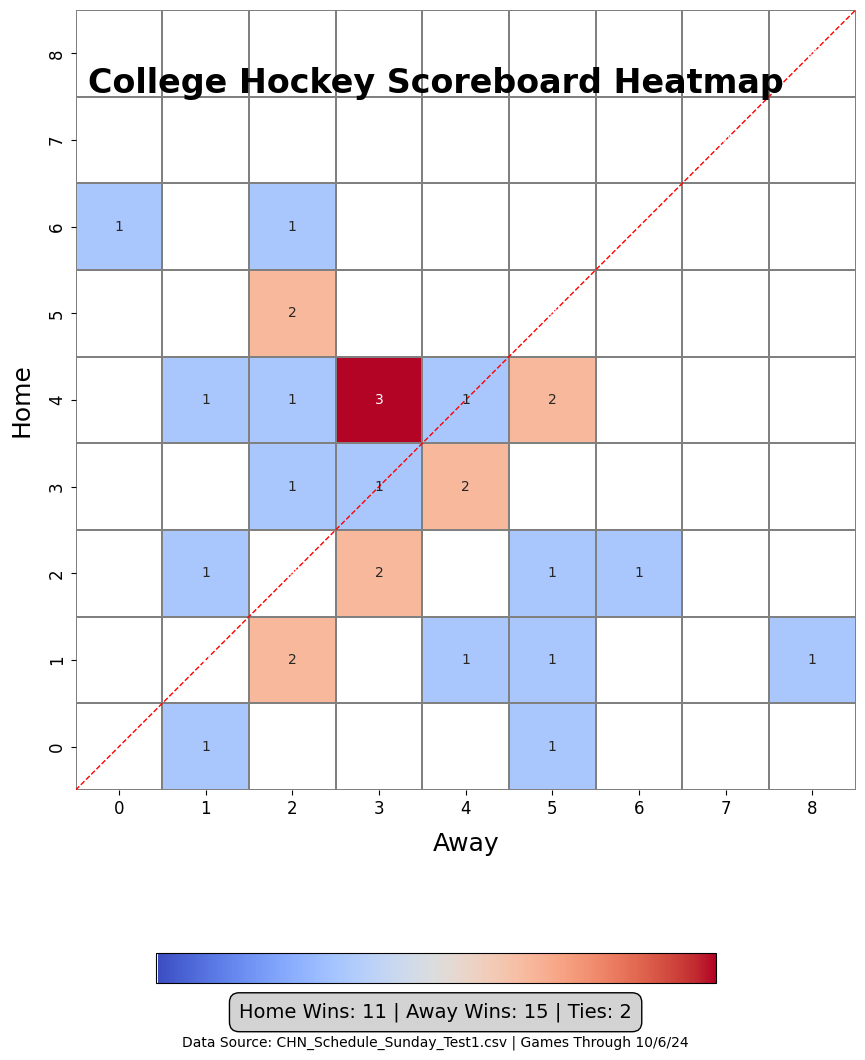

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap

# Define figure size to maintain a 4:5 ratio while ensuring the heatmap grid stays 1:1
figure_ratio = (8, 10)  # Adjusted for mobile-friendly aspect ratio

# Customizing the colormap with transparency for zeros
cmap = sns.color_palette(palette='coolwarm', as_cmap=True)
cmap_with_transparency = ListedColormap([(0,0,0,0)] + [cmap(i) for i in range(1, cmap.N)])

# Create a figure with constrained layout to ensure the grid aspect stays 1:1
fig = plt.figure(figsize=figure_ratio)

# Create the title
plt.suptitle('College Hockey Scoreboard Heatmap', fontsize=24, fontweight='bold', color='black', y=0.98)

# Create a new axis for the heatmap with the grid maintaining a 1:1 aspect ratio
# ax1 = fig.add_axes([0.1, 0.055, 0.8, 0.35])  # Adjusted placement to reduce whitespace # Terrible spacing
ax1 = fig.add_axes([0.05, 0.15, 0.975, 0.995])  # Adjusted placement to reduce whitespace
sns.heatmap(score_combinations, annot=True, mask=None, cmap=cmap_with_transparency, fmt="d", linewidths=.25, 
            linecolor='gray', cbar=False, square=True, ax=ax1)

# Invert y-axis to ensure 0 is at the bottom
ax1.invert_yaxis()

# Axis labels
ax1.set_xlabel('Away', fontsize=18, labelpad=10)
ax1.set_ylabel('Home', fontsize=18, labelpad=10)

# Customize tick labels
ax1.set_xticks(np.arange(0.5, len(all_scores)+0.5, 1))
ax1.set_xticklabels(all_scores, fontsize=12)
ax1.set_yticks(np.arange(0.5, len(all_scores)+0.5, 1))
ax1.set_yticklabels(all_scores, fontsize=12)

# Add a diagonal line for home vs away parity
ax1.plot([0, len(all_scores)], [0, len(all_scores)], color='red', linestyle='--', linewidth=1)

# Create a new axis for the color bar below the heatmap
ax2 = fig.add_axes([0.15, 0.065, 0.7, 0.03])  # Adjust placement for color bar
cbar = plt.colorbar(ax1.collections[0], cax=ax2, orientation='horizontal')
# Remove color bar labels
cbar.set_ticks([])
# cbar.set_label('Game Frequency', fontsize=14) # Uncomment to add a label

# Add the leaderboard box below the color bar
props = dict(boxstyle='round,pad=0.5', facecolor='lightgray', edgecolor='black')
leaderboard_text = f'Home Wins: {home_wins} | Away Wins: {away_wins} | Ties: {ties}'
plt.text(0.5, 0.03, leaderboard_text, fontsize=14, color='black', ha='center', bbox=props, transform=fig.transFigure)

# Add data source and date at the very bottom
plt.figtext(0.5, .001, f'Data Source: {filename}.csv | Games Through {date}', fontsize=10, color='black', ha='center')

# Adjust the layout to reduce overall whitespace
plt.subplots_adjust(top=0.85, bottom=0.15, left=0.1, right=0.9, hspace=0.2)

# Display the plot
plt.show()


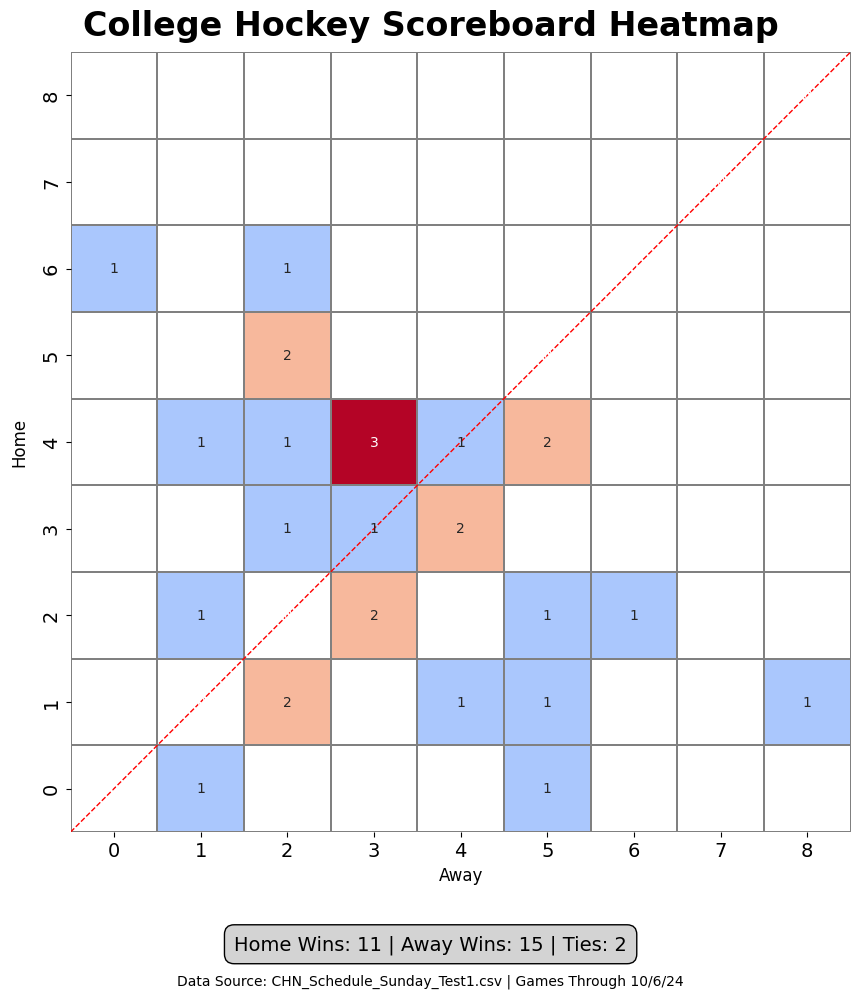

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap

# Define figure size to maintain a 4:5 ratio while ensuring the heatmap grid stays 1:1
figure_ratio = (8, 10)  # Adjusted for mobile-friendly aspect ratio

# Customizing the colormap with transparency for zeros
cmap = sns.color_palette(palette='coolwarm', as_cmap=True)
cmap_with_transparency = ListedColormap([(0,0,0,0)] + [cmap(i) for i in range(1, cmap.N)])

# Create a figure with constrained layout to ensure the grid aspect stays 1:1
fig = plt.figure(figsize=figure_ratio)

# Create the title
plt.suptitle('College Hockey Scoreboard Heatmap', fontsize=24, fontweight='bold', color='black', y=0.98)

# Create a new axis for the heatmap with the grid maintaining a 1:1 aspect ratio
# ax1 = fig.add_axes([0.05, 0.2, 0.98, 0.6])  # Adjusted placement to reduce whitespace
# Placement for mobile-friendly aspect ratio
ax1 = fig.add_axes([0.05, 0.05, 0.975, 0.995])  # Adjusted placement to reduce whitespace
sns.heatmap(score_combinations, annot=True, mask=None, cmap=cmap_with_transparency, fmt="d", linewidths=.25, 
            linecolor='gray', cbar=False, square=True, ax=ax1)

# Invert y-axis to ensure 0 is at the bottom
ax1.invert_yaxis()

# Axis labels
ax1.set_xlabel('Away', fontsize=12) #, labelpad=10)
# Rotate the y-axis label 90 degrees for better readability
ax1.set_ylabel('Home', fontsize=12, rotation=90, labelpad=10)



# ax1.set_ylabel('Home', fontsize=12) # labelpad=10)

# Customize tick labels
ax1.set_xticks(np.arange(0.5, len(all_scores)+0.5, 1))
ax1.set_xticklabels(all_scores, fontsize=14)
ax1.set_yticks(np.arange(0.5, len(all_scores)+0.5, 1))
ax1.set_yticklabels(all_scores, fontsize=14)

# Add a diagonal line for home vs away parity
ax1.plot([0, len(all_scores)], [0, len(all_scores)], color='red', linestyle='--', linewidth=1)

# # Create a new axis for the color bar below the heatmap
# ax2 = fig.add_axes([0.15, 0.1, 0.7, 0.02])  # Adjust placement for color bar
# cbar = plt.colorbar(ax1.collections[0], cax=ax2, orientation='horizontal')
# Restored the color bar label for clarity
# cbar.set_label('Game Frequency', fontsize=14) # Uncomment to add a label - DUMB

# Add the leaderboard box below the color bar
props = dict(boxstyle='round,pad=0.5', facecolor='lightgray', edgecolor='black')
leaderboard_text = f'Home Wins: {home_wins} | Away Wins: {away_wins} | Ties: {ties}'
plt.text(0.5, 0.04, leaderboard_text, fontsize=14, color='black', ha='center', bbox=props, transform=fig.transFigure)

# Add data source and date at the very bottom with better padding
plt.figtext(0.5, 0.005, f'Data Source: {filename}.csv | Games Through {date}', fontsize=10, color='black', ha='center')

# Adjust the layout to reduce overall whitespace
plt.subplots_adjust(top=0.95, bottom=0.5, left=0.1, right=0.9, hspace=0.2)

# Display the plot
plt.show()
